In [16]:
!pip -q install kmodes gower


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    silhouette_score, silhouette_samples,
    davies_bouldin_score, calinski_harabasz_score
)
from sklearn.cluster import KMeans

from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes
import inspect, sys


df = pd.read_csv('data_encoded (3).csv').drop_duplicates().reset_index(drop=True)
print("Data shape:", df.shape)
df.head()


Data shape: (1325, 7)


,age,bmi,children,region,charges,sex_male,smoker_yes
0,19.0,27.900,0.0,3,16884.92400,0,1
1,18.0,33.770,1.0,2,1725.55230,1,0
2,28.0,33.000,3.0,2,4449.46200,1,0
3,33.0,22.705,0.0,1,21984.47061,1,0
4,32.0,28.880,0.0,1,3866.85520,1,0


In [18]:

for c in df.columns:
    if df[c].dtype == bool:
        df[c] = df[c].astype(int)

target_col = next((c for c in df.columns if c.lower() in {"charges","price","target","y"}), None)
X = df.drop(columns=[target_col]) if target_col else df.copy()

print("Dropped target:", target_col)


Dropped target: charges


In [19]:
num_cols, cat_cols = [], []
for c in X.columns:
    kind = X[c].dtype.kind
    if kind in "f":
        num_cols.append(c)
    elif kind in "iu":
        (cat_cols if X[c].nunique(dropna=True) <= 8 else num_cols).append(c)
    else:
        cat_cols.append(c)

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['age', 'bmi', 'children']
Categorical columns: ['region', 'sex_male', 'smoker_yes']


In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def make_ohe():

    if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    else:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipe = Pipeline([("scaler", StandardScaler())])
cat_pipe = Pipeline([("oh", make_ohe())]) if cat_cols else "drop"

preprocess_onehot = ColumnTransformer(
    [("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
    remainder="drop"
)

X_onehot = preprocess_onehot.fit_transform(X)
X_mixed = X.copy()
for c in cat_cols:
    X_mixed[c] = X_mixed[c].astype(str)

print("X_onehot shape:", X_onehot.shape)


X_onehot shape: (1325, 11)


In [21]:
import gower

N = len(X_mixed)
GOWER_N_MAX = 6000

HAVE_GOWER = False
D_gower = None

if N <= GOWER_N_MAX:
    cols_order = num_cols + cat_cols
    D_gower = gower.gower_matrix(X_mixed[cols_order])
    HAVE_GOWER = True
    print("Gower distance shape:", D_gower.shape)
else:
    print(f"⚠️ Dataset has {N} rows; skipping Gower (limit {GOWER_N_MAX}). Set a sample or raise the limit if needed.")


Gower distance shape: (1325, 1325)


In [22]:
from sklearn.metrics import silhouette_score, silhouette_samples

def full_internal_metrics(X_euclid, labels, D_precomp=None):
    """Compute internal metrics on Euclidean space + optional Gower silhouette."""
    res = {}
    try:
        res["silhouette_euclid"] = silhouette_score(X_euclid, labels, metric="euclidean")
        res["db_index"]          = davies_bouldin_score(X_euclid, labels)
        res["calinski"]          = calinski_harabasz_score(X_euclid, labels)
    except Exception:
        res["silhouette_euclid"] = np.nan
        res["db_index"]          = np.nan
        res["calinski"]          = np.nan

    if D_precomp is not None:
        try:
            res["silhouette_gower"] = silhouette_score(D_precomp, labels, metric="precomputed")
        except Exception:
            res["silhouette_gower"] = np.nan
    else:
        res["silhouette_gower"] = np.nan
    return res

def silhouette_plot_precomputed(D, labels, title="Silhouette (Gower)"):
    s = silhouette_samples(D, labels, metric="precomputed")
    y_lower = 10
    plt.figure(figsize=(7,5))
    for k in sorted(np.unique(labels)):
        si = np.sort(s[labels==k])
        size_i = si.shape[0]
        y_upper = y_lower + size_i
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, si)
        plt.text(-0.05, y_lower + 0.5*size_i, str(k))
        y_lower = y_upper + 10
    plt.axvline(np.mean(s), linestyle="--")
    plt.title(f"{title} | mean={np.mean(s):.3f}")
    plt.xlabel("silhouette value")
    plt.ylabel("cluster")
    plt.tight_layout()
    plt.show()

def silhouette_plot_euclid(X_euclid, labels, title="Silhouette (Euclidean)"):
    s = silhouette_samples(X_euclid, labels, metric="euclidean")
    y_lower = 10
    plt.figure(figsize=(7,5))
    for k in sorted(np.unique(labels)):
        si = np.sort(s[labels==k])
        size_i = si.shape[0]
        y_upper = y_lower + size_i
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, si)
        plt.text(-0.05, y_lower + 0.5*size_i, str(k))
        y_lower = y_upper + 10
    plt.axvline(np.mean(s), linestyle="--")
    plt.title(f"{title} | mean={np.mean(s):.3f}")
    plt.xlabel("silhouette value")
    plt.ylabel("cluster")
    plt.tight_layout()
    plt.show()


In [23]:
results = []
assignments = {}

for k in range(2, 11):
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_onehot)
    metrics = full_internal_metrics(X_onehot, labels, D_precomp=D_gower if HAVE_GOWER else None)
    metrics.update(alg="KMeans(one-hot)", k=k)
    results.append(metrics)
    assignments[("KMeans(one-hot)", k)] = labels

pd.DataFrame(results).sort_values(
    ["silhouette_gower","silhouette_euclid"], ascending=[False, False]
).head(10)


,silhouette_euclid,db_index,calinski,silhouette_gower,alg,k
1,0.181924,1.738795,285.847006,0.130868,KMeans(one-hot),3
0,0.162117,2.124021,271.454359,0.127345,KMeans(one-hot),2
2,0.171219,1.597760,263.324438,0.102819,KMeans(one-hot),4
7,0.141937,1.834147,176.669462,0.083448,KMeans(one-hot),9
5,0.141393,1.868214,200.431433,0.079613,KMeans(one-hot),7
3,0.144799,1.741605,233.952242,0.075926,KMeans(one-hot),5
4,0.139233,1.856522,214.331316,0.074256,KMeans(one-hot),6
8,0.142440,1.838184,168.100014,0.072191,KMeans(one-hot),10
6,0.135414,1.815230,187.381450,0.051595,KMeans(one-hot),8


In [24]:
cols_order = num_cols + cat_cols
cat_idx = [cols_order.index(c) for c in cat_cols]

for k in range(2, 11):
    kp = KPrototypes(n_clusters=k, init='Huang', random_state=42)
    labels = kp.fit_predict(X_mixed[cols_order].to_numpy(), categorical=cat_idx)
    metrics = full_internal_metrics(X_onehot, labels, D_precomp=D_gower if HAVE_GOWER else None)
    metrics.update(alg="KPrototypes(mixed)", k=k)
    results.append(metrics)
    assignments[("KPrototypes(mixed)", k)] = labels

pd.DataFrame(results).sort_values(
    ["silhouette_gower","silhouette_euclid"], ascending=[False, False]
).head(10)


,silhouette_euclid,db_index,calinski,silhouette_gower,alg,k
9,0.159594,2.175438,262.609863,0.135093,KPrototypes(mixed),2
1,0.181924,1.738795,285.847006,0.130868,KMeans(one-hot),3
0,0.162117,2.124021,271.454359,0.127345,KMeans(one-hot),2
2,0.171219,1.597760,263.324438,0.102819,KMeans(one-hot),4
10,0.089200,2.972752,173.879785,0.100560,KPrototypes(mixed),3
11,0.084330,2.347741,167.734473,0.083920,KPrototypes(mixed),4
7,0.141937,1.834147,176.669462,0.083448,KMeans(one-hot),9
5,0.141393,1.868214,200.431433,0.079613,KMeans(one-hot),7
3,0.144799,1.741605,233.952242,0.075926,KMeans(one-hot),5
4,0.139233,1.856522,214.331316,0.074256,KMeans(one-hot),6


In [25]:
if len(cat_cols) > 0:
    X_cat_only = X_mixed[cat_cols].astype(str)
    for k in range(2, 11):
        kmodes = KModes(n_clusters=k, init='Huang', random_state=42)
        labels = kmodes.fit_predict(X_cat_only)
        metrics = full_internal_metrics(X_onehot, labels, D_precomp=D_gower if HAVE_GOWER else None)
        metrics.update(alg="KModes(categorical)", k=k)
        results.append(metrics)
        assignments[("KModes(categorical)", k)] = labels
else:
    print("No categorical columns detected; skipping KModes.")


In [26]:
class KMedoidsPAMPrecomputed:
    """PAM K-Medoids for a precomputed distance matrix D (NxN)."""
    def __init__(self, n_clusters=3, max_iter=200, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.labels_ = None
        self.cluster_centers_ = None

    def _assign(self, D, medoids):
        d_med = D[:, medoids]      # (N, k)
        return np.argmin(d_med, axis=1)

    def _cost(self, D, labels, medoids):
        rows = np.arange(D.shape[0])
        return float(np.sum(D[rows, medoids[labels]]))

    def fit(self, D):
        N = D.shape[0]
        rng = np.random.default_rng(self.random_state)
        medoids = rng.choice(N, size=self.n_clusters, replace=False)
        labels = self._assign(D, medoids)
        best_cost = self._cost(D, labels, medoids)

        for _ in range(self.max_iter):
            improved = False
            for m_idx in range(self.n_clusters):
                for h in range(N):
                    if h in medoids:
                        continue
                    new_medoids = medoids.copy()
                    new_medoids[m_idx] = h
                    new_labels = self._assign(D, new_medoids)
                    new_cost = self._cost(D, new_labels, new_medoids)
                    if new_cost + 1e-12 < best_cost:
                        medoids, labels, best_cost = new_medoids, new_labels, new_cost
                        improved = True
            if not improved:
                break

        self.cluster_centers_ = medoids
        self.labels_ = labels
        return self

    def fit_predict(self, D):
        return self.fit(D).labels_


In [27]:
if HAVE_GOWER:
    for k in range(2, 11):
        kmed = KMedoidsPAMPrecomputed(n_clusters=k, max_iter=200, random_state=42)
        labels = kmed.fit_predict(D_gower)
        metrics = full_internal_metrics(X_onehot, labels, D_precomp=D_gower)
        metrics.update(alg="KMedoids(Gower-PAM)", k=k)
        results.append(metrics)
        assignments[("KMedoids(Gower-PAM)", k)] = labels
else:
    print("Skipping K-Medoids(Gower-PAM): no Gower distance.")


In [28]:
res_df = pd.DataFrame(results)

if HAVE_GOWER:
    res_df_sorted = res_df.sort_values(
        ["silhouette_gower","silhouette_euclid","calinski"],
        ascending=[False, False, False]
    ).reset_index(drop=True)
else:
    res_df_sorted = res_df.sort_values(
        ["silhouette_euclid","calinski","db_index"],
        ascending=[False, False, True]
    ).reset_index(drop=True)

res_df_sorted.head(20)


,silhouette_euclid,db_index,calinski,silhouette_gower,alg,k
0,0.135764,2.389049,78.050690,0.474314,KMedoids(Gower-PAM),8
1,0.131439,2.321830,74.160326,0.454799,KMedoids(Gower-PAM),9
2,0.130998,2.313999,69.349569,0.452433,KMedoids(Gower-PAM),10
3,0.113457,2.430961,67.641640,0.409349,KModes(categorical),9
4,0.110793,2.441847,59.852362,0.402314,KModes(categorical),10
5,0.116048,2.478070,71.266247,0.387748,KModes(categorical),8
6,0.108817,2.553171,77.943862,0.378016,KMedoids(Gower-PAM),7
7,0.122549,2.737315,164.194957,0.354933,KModes(categorical),2
8,0.122549,2.737315,164.194957,0.354933,KMedoids(Gower-PAM),2
9,0.104804,2.683182,74.238434,0.349781,KModes(categorical),7


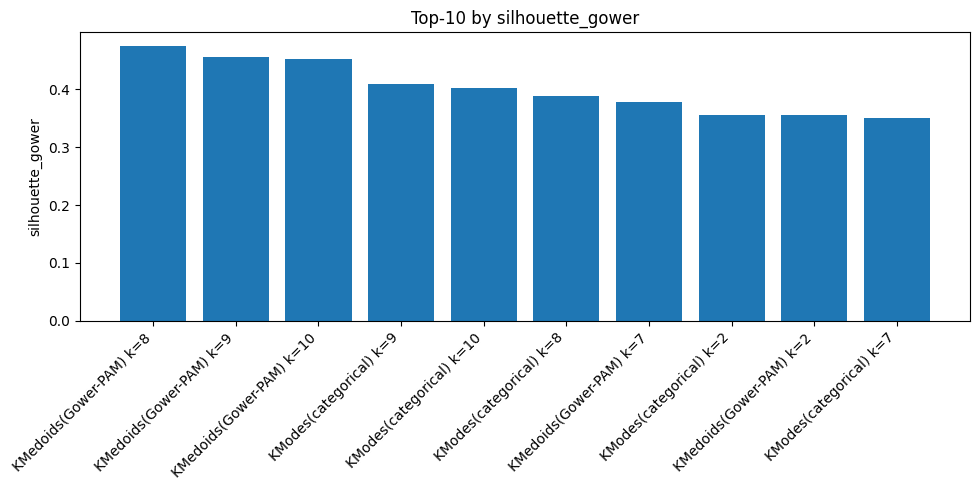

In [29]:
top = res_df_sorted.head(10).copy()
metric = "silhouette_gower" if HAVE_GOWER else "silhouette_euclid"
plt.figure(figsize=(10,5))
plt.bar(top["alg"] + " k=" + top["k"].astype(str), top[metric])
plt.xticks(rotation=45, ha="right")
plt.title(f"Top-10 by {metric}")
plt.ylabel(metric)
plt.tight_layout()
plt.show()


Best: ('KMedoids(Gower-PAM)', 8) | {'silhouette_euclid': 0.13576387245131585, 'db_index': 2.389049209952545, 'calinski': 78.05069024911118, 'silhouette_gower': 0.47431376576423645, 'alg': 'KMedoids(Gower-PAM)', 'k': 8}
Second: ('KMedoids(Gower-PAM)', 9) | {'silhouette_euclid': 0.1314388607708139, 'db_index': 2.321829602336111, 'calinski': 74.1603261809392, 'silhouette_gower': 0.45479878783226013, 'alg': 'KMedoids(Gower-PAM)', 'k': 9}


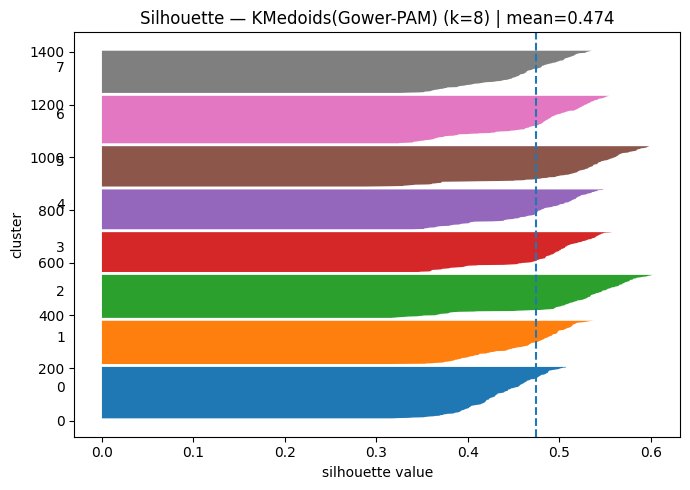

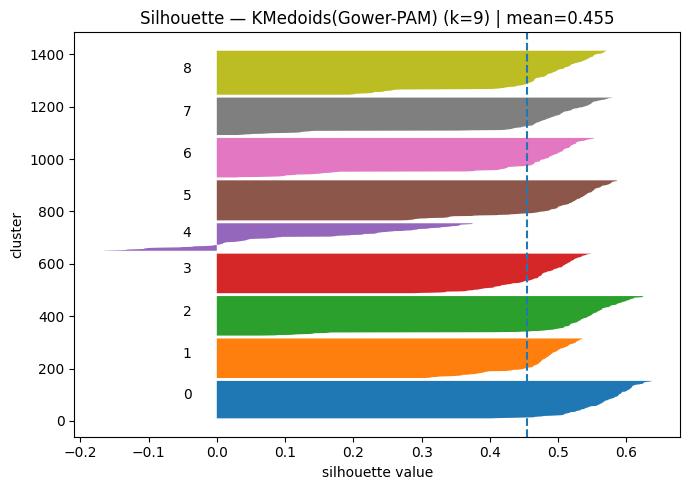

In [30]:
best = res_df_sorted.iloc[0]
second = res_df_sorted.iloc[1]

best_key   = (best["alg"],   int(best["k"]))
second_key = (second["alg"], int(second["k"]))

print("Best:", best_key,   "|", best.to_dict())
print("Second:", second_key, "|", second.to_dict())

if HAVE_GOWER:
    silhouette_plot_precomputed(D_gower, assignments[best_key],   f"Silhouette — {best_key[0]} (k={best_key[1]})")
    silhouette_plot_precomputed(D_gower, assignments[second_key], f"Silhouette — {second_key[0]} (k={second_key[1]})")
else:
    silhouette_plot_euclid(X_onehot, assignments[best_key],   f"Silhouette — {best_key[0]} (k={best_key[1]})")
    silhouette_plot_euclid(X_onehot, assignments[second_key], f"Silhouette — {second_key[0]} (k={second_key[1]})")


In [31]:
from IPython.display import display

def cluster_profile(df_raw, labels, num_cols, cat_cols):
    prof_num = df_raw.groupby(labels)[num_cols].mean() if num_cols else pd.DataFrame()
    prof_cat = []
    for c in cat_cols:
        freq = df_raw.groupby(labels)[c].value_counts(normalize=True).rename("pct").reset_index()
        top3 = freq.sort_values(["level_0","pct"], ascending=[True,False]).groupby("level_0").head(3)
        top3 = top3.rename(columns={"level_0":"cluster", c:"category"})
        top3["feature"] = c
        prof_cat.append(top3[["cluster","feature","category","pct"]])
    prof_cat = pd.concat(prof_cat) if prof_cat else pd.DataFrame()
    return prof_num, prof_cat

best_labels   = assignments[best_key]
second_labels = assignments[second_key]

num_profile_best,   cat_profile_best   = cluster_profile(X_mixed, best_labels,   num_cols, cat_cols)
num_profile_second, cat_profile_second = cluster_profile(X_mixed, second_labels, num_cols, cat_cols)

print("=== Best solution: numeric means ===")
display(num_profile_best)
print("=== Best solution: top categorical frequencies ===")
display(cat_profile_best)

print("=== Second solution: numeric means ===")
display(num_profile_second)
print("=== Second solution: top categorical frequencies ===")
display(cat_profile_second)


=== Best solution: numeric means ===


,age,bmi,children
0,38.086735,33.671122,1.056122
1,38.903030,28.937000,1.054545
2,38.506098,29.126189,1.146341
3,39.684211,29.463750,1.125000
4,39.921053,29.191250,0.993421
5,39.246753,29.911039,1.084416
6,39.099448,32.434448,1.099448
7,39.751553,31.048447,1.167702


=== Best solution: top categorical frequencies ===


,cluster,feature,category,pct
0,0,region,2,1.000000
1,1,region,0,1.000000
2,2,region,1,1.000000
3,3,region,1,1.000000
4,4,region,0,1.000000
5,5,region,3,1.000000
6,6,region,2,1.000000
7,7,region,3,1.000000
0,0,sex_male,1,1.000000
1,1,sex_male,1,1.000000


=== Second solution: numeric means ===


,age,bmi,children
0,38.131944,33.879410,1.048611
1,39.684211,29.463750,1.125000
2,39.710526,29.070000,1.144737
3,39.921053,29.191250,0.993421
4,30.811321,31.740047,1.009434
5,39.246753,29.911039,1.084416
6,40.296053,29.056250,1.118421
7,41.340278,30.911111,1.152778
8,40.266272,32.489970,1.112426


=== Second solution: top categorical frequencies ===


,cluster,feature,category,pct
0,0,region,2,1.000000
1,1,region,1,1.000000
2,2,region,1,1.000000
3,3,region,0,1.000000
4,4,region,2,0.603774
5,4,region,3,0.160377
6,4,region,0,0.122642
8,5,region,3,1.000000
9,6,region,0,1.000000
10,7,region,3,1.000000


In [32]:

out_best = df.copy()
out_second = df.copy()

col_best   = f"cluster__{best_key[0]}__k{best_key[1]}"
col_second = f"cluster__{second_key[0]}__k{second_key[1]}"

out_best[col_best]     = assignments[best_key]
out_second[col_second] = assignments[second_key]

best_path   = f"/content/{col_best}.csv"
second_path = f"/content/{col_second}.csv"
leader_path = "/content/unsupervised_leaderboard.csv"

out_best.to_csv(best_path, index=False)
out_second.to_csv(second_path, index=False)
res_df_sorted.to_csv(leader_path, index=False)

print("Saved:")
print(" -", best_path)
print(" -", second_path)
print(" -", leader_path)


Saved:
 - /content/cluster__KMedoids(Gower-PAM)__k8.csv
 - /content/cluster__KMedoids(Gower-PAM)__k9.csv
 - /content/unsupervised_leaderboard.csv
